# React Agent for Text-to-SQL with LangGraph

This notebook implements a proper ReAct agent using LangGraph's `create_react_agent` with three main tools:
1. **Look up evidence** - Query the vector database for relevant SQL examples
2. **Run SQL against database** - Execute SQL queries against the specified database
3. **Get database schema** - Retrieve the schema/structure of a specific database

The agent can reason about when to use each tool and iterate as needed.


In [1]:
%env OPENAI_API_KEY=your-openai-api-key-here
%env OPENROUTER_API_KEY=your-openrouter-api-key-here


env: OPENAI_API_KEY=your-openai-api-key-here
env: OPENROUTER_API_KEY=your-openrouter-api-key-here


In [18]:
# Import required libraries
import os
import json
import sqlite3
from typing import List, Dict, Any, Optional
import chromadb
from chromadb.config import Settings

# LangChain and LangGraph imports
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_chroma import Chroma
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver

# Local imports
from utils import describe_database


## Setup Vector Database and Load SQL Examples


In [3]:
# Initialize embeddings and ChromaDB
embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

# Initialize ChromaDB (clean slate)
chroma_client = chromadb.PersistentClient(
    path="./chromadb_react_agent",
    settings=Settings(anonymized_telemetry=False)
)

# Clean up existing collection if it exists
try:
    chroma_client.delete_collection("sql_examples")
except Exception:
    pass  # Ignore if collection doesn't exist

# Initialize vector store
vector_store = Chroma(
    client=chroma_client,
    collection_name="sql_examples",
    embedding_function=embeddings,
    collection_metadata={"hnsw:space": "cosine"}
)

print("✅ Vector database initialized")


✅ Vector database initialized


In [19]:
# Load and prepare SQL examples from dev.json
with open('../dev.json', 'r') as f:
    dev_data = json.load(f)

print(f"📚 Loaded {len(dev_data)} SQL examples")
print(f"Example: {dev_data[0]['question'][:100]}...")


📚 Loaded 1534 SQL examples
Example: What is the highest eligible free rate for K-12 students in the schools in Alameda County?...


In [5]:
# Create documents from SQL examples
from langchain_core.documents import Document

documents = []
for item in dev_data:
    # Create comprehensive document with all relevant information
    evidences = [e.strip() for e in item['evidence'].split(';') if e.strip()]
    
    for evidence in evidences:
        doc = Document(
            page_content=evidence,
            metadata={
                "db_id": item["db_id"],
                "question": item["question"],
                "sql": item["SQL"]
            }
        )
        documents.append(doc)

# Add documents to vector store
print(f"📤 Adding {len(documents)} documents to vector store...")
vector_store.add_documents(documents)
print(f"✅ Added {len(documents)} SQL evidence examples to the vector store")

# Show database distribution
db_counts = {}
for item in dev_data:
    db_id = item['db_id']
    db_counts[db_id] = db_counts.get(db_id, 0) + 1

print(f"\n📊 Available databases:")
for db_id, count in sorted(db_counts.items()):
    print(f"  - {db_id}: {count} examples")


📤 Adding 2680 documents to vector store...
✅ Added 2680 SQL evidence examples to the vector store

📊 Available databases:
  - california_schools: 89 examples
  - card_games: 191 examples
  - codebase_community: 186 examples
  - debit_card_specializing: 64 examples
  - european_football_2: 129 examples
  - financial: 106 examples
  - formula_1: 174 examples
  - student_club: 158 examples
  - superhero: 129 examples
  - thrombosis_prediction: 163 examples
  - toxicology: 145 examples


## Define ReAct Agent Tools


In [20]:
@tool
def look_up_evidence(query: str, database_id: str = "", k: int = 5) -> str:
    """
    Look up relevant SQL evidence/examples from the vector database.
    
    Args:
        query: The question or query to find relevant SQL examples for
        database_id: Optional database ID to filter results (e.g., 'formula_1', 'california_schools')
        k: Number of examples to retrieve (default: 5)
    
    Returns:
        String containing relevant SQL evidence and examples
    """
    
    try:
        # Perform similarity search with optional filtering
        search_kwargs = {"k": k}
        if database_id:
            search_kwargs["filter"] = {"db_id": database_id}
        
        results = vector_store.similarity_search_with_score(query, **search_kwargs)
        
        if not results:
            return f"No relevant evidence found for query: '{query}'"
        
        # Format results
        evidence_text = f"Found {len(results)} relevant examples:\n\n"
        
        for i, (doc, score) in enumerate(results, 1):
            similarity = 1 - score  # Convert distance to similarity
            evidence_text += f"Example {i} (similarity: {similarity:.3f}):\n"
            evidence_text += f"Database: {doc.metadata['db_id']}\n"
            evidence_text += f"Evidence: {doc.page_content}\n"
            if 'question' in doc.metadata:
                evidence_text += f"Related Question: {doc.metadata['question']}\n"
            if 'sql' in doc.metadata:
                evidence_text += f"SQL Example: {doc.metadata['sql']}\n"
            evidence_text += "-" * 50 + "\n"
        
        return evidence_text
        
    except Exception as e:
        error_msg = f"Error looking up evidence: {str(e)}"
        return error_msg


In [21]:
@tool
def run_sql_against_database(sql_query: str, database_id: str) -> str:
    """
    Execute a SQL query against the specified database.
    
    Args:
        sql_query: The SQL query to execute
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')
    
    Returns:
        String containing the query results or error message
    """
    
    try:
        # Construct database path
        db_path = f"../dbs/dev_databases/{database_id}/{database_id}.sqlite"
        
        if not os.path.exists(db_path):
            return f"Error: Database '{database_id}' not found at {db_path}"
        
        # Connect and execute query
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()
        
        cursor.execute(sql_query)
        
        # Get results
        columns = [description[0] for description in cursor.description] if cursor.description else []
        results = cursor.fetchall()
        
        conn.close()
        
        # Format results
        if not results:
            result_text = "Query executed successfully but returned no results."
        else:
            result_text = f"Query executed successfully! Found {len(results)} row(s):\n\n"
            
            # Add column headers
            if columns:
                result_text += " | ".join(columns) + "\n"
                result_text += "-" * (len(" | ".join(columns))) + "\n"
            
            # Add data rows (limit to first 10 for readability)
            for row in results[:10]:
                result_text += " | ".join(str(cell) if cell is not None else "NULL" for cell in row) + "\n"
            
            if len(results) > 10:
                result_text += f"\n... and {len(results) - 10} more row(s)"
        
        return result_text
        
    except Exception as e:
        error_msg = f"Error executing SQL query: {str(e)}"
        return error_msg


@tool
def get_database_schema(database_id: str) -> str:
    """
    Get the schema description for a specific database.
    
    Args:
        database_id: The database identifier (e.g., 'formula_1', 'california_schools')
    
    Returns:
        String containing the database schema information including tables, columns, and relationships
    """
    
    try:
        db_path = f"../dbs/dev_databases/{database_id}/{database_id}.sqlite"
        
        if not os.path.exists(db_path):
            return f"Error: Database '{database_id}' not found at {db_path}"
        
        schema = describe_database(db_path)
        return f"Database Schema for '{database_id}':\n\n{schema}"
        
    except Exception as e:
        error_msg = f"Error getting database schema: {str(e)}"
        return error_msg


## Create the ReAct Agent


In [24]:
from os import getenv

# Initialize the language model
llm = ChatOpenAI(
  model="openai/gpt-4.1-mini", 
  temperature=0,
  base_url="https://openrouter.ai/api/v1",
  api_key=getenv("OPENROUTER_API_KEY"),
  extra_body={
            "usage": {"include": True}
        }
  )

# Define the tools for the agent
tools = [look_up_evidence, run_sql_against_database, get_database_schema]

# Create the ReAct agent using LangGraph's create_react_agent
checkpointer = MemorySaver()  # For conversation memory

react_agent = create_react_agent(
    model=llm,
    tools=tools,
    checkpointer=checkpointer,
    prompt="""You are a helpful SQL assistant. You can:
1. Look up relevant SQL evidence/examples from a vector database using the `look_up_evidence` tool
2. Execute SQL queries against databases using the `run_sql_against_database` tool
3. Describe the database using the `get_database_schema` tool

When a user asks a question that could be answered with SQL:
1. First, describe the database using the `get_database_schema` tool if you haven't already
2. Then, look up evidence for similar SQL examples that might help using the `look_up_evidence` tool
3. Generate and execute the appropriate SQL query using the database_id from the evidence using the `run_sql_against_database` tool
4. Provide a clear answer to the user

Be thorough in your reasoning and explain your approach.

Available databases:
  - california_schools
  - card_games
  - codebase_community
  - debit_card_specializing
  - european_football_2
  - financial
  - formula_1
  - student_club
  - superhero
  - thrombosis_prediction
  - toxicology"""
)

print("✅ ReAct agent created successfully!")


✅ ReAct agent created successfully!


## Test the ReAct Agent


📊 ReAct Agent LangGraph Visualization:


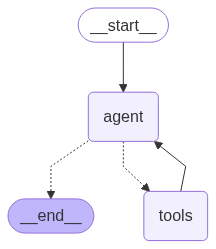

In [25]:
from IPython.display import Image, display

# Get the graph visualization as PNG bytes
png_bytes = react_agent.get_graph().draw_mermaid_png()

# Save the PNG to a file
with open("react_agent_graph.png", "wb") as f:
    f.write(png_bytes)

print("📊 ReAct Agent LangGraph Visualization:")
display(Image("react_agent_graph.png"))


In [26]:
import json

# Stream events with a sample query
def stream_agent_events(question: str, thread_id: str = "stream_test"):
    """Stream events from the ReAct agent for a given question"""
    print(f"\n{'='*60}")
    print(f"🔄🟢 Streaming ReAct Agent Events")
    print(f'🧑 User said: {question}')
    print(f"{'='*60}\n")
    
    config = {"configurable": {"thread_id": thread_id}}
    
    # The agent must support streaming; assume .stream() yields events
    for event in react_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config
    ):
        if 'agent' in event:
            for message in event['agent']['messages']:
                if message.content:
                    print(f'🤖 Agent said: {message.content}')
                if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
                    for tool_call in message.additional_kwargs['tool_calls']:
                        if 'function' in tool_call:
                            print(f'🛠️ Tool called: {tool_call["function"]["name"]}')
                            if 'arguments' in tool_call["function"]:
                                for tool_arg_key, tool_arg_value in json.loads(tool_call["function"]["arguments"]).items():
                                    print(f'   🔑 {tool_arg_key}: {tool_arg_value}')
        elif 'tools' in event:
            for message in event['tools']['messages']:
                print(f'📦 Tool response: {message.content[:100]}...')
        else:
            print(f'⚡ Event: {event}')
    
    print(f"\n{'='*60}")

In [117]:
# Get the 34th dev example for formula_1
example = [d for d in dev_data if d['db_id'] == 'formula_1'][33]
print("Question:", example['question'])
print("SQL:", example['SQL'])

# Run the SQL against the formula_1 database to get the answer
import sqlite3

db_path = f"../dbs/dev_databases/{example['db_id']}/{example['db_id']}.sqlite"
conn = sqlite3.connect(db_path)
cur = conn.cursor()
try:
    cur.execute(example['SQL'])
    answer = cur.fetchall()
    print("Answer:", answer)
finally:
    cur.close()
    conn.close()

Question: For the driver who set the fastest lap speed, what is his nationality?
SQL: SELECT T1.nationality FROM drivers AS T1 INNER JOIN results AS T2 ON T2.driverId = T1.driverId ORDER BY T2.fastestLapSpeed DESC LIMIT 1
Answer: [('Italian',)]


In [118]:
# Example usage: stream a sample query
stream_agent_events(
    example['question'],
    "formula1_stream"
)


🔄🟢 Streaming ReAct Agent Events
🧑 User said: For the driver who set the fastest lap speed, what is his nationality?

{'agent': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_0OOV2wEYP2el7D67AS88sTBk', 'function': {'arguments': '{"query":"fastest lap speed driver nationality"}', 'name': 'look_up_evidence'}, 'type': 'function', 'index': 0}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 529, 'total_tokens': 550, 'completion_tokens_details': {'accepted_prediction_tokens': None, 'audio_tokens': None, 'reasoning_tokens': 0, 'rejected_prediction_tokens': None}, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'cost': 9.808e-06, 'is_byok': True, 'cost_details': {'upstream_inference_cost': 0.0002452}}, 'model_name': 'openai/gpt-4.1-mini', 'system_fingerprint': 'fp_6f2eabb9a5', 'id': 'gen-1750993100-rDwED2tr9Gj8ldZvev8G', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None

In [12]:
# ask a follow up question
stream_agent_events(
    "How about the slowest lap speed?",
    "formula1_stream"
)


🔄🟢 Streaming ReAct Agent Events
🧑 User said: How about the slowest lap speed?

🛠️ Tool called: run_sql_against_database
   🔑 sql_query: SELECT T1.nationality FROM drivers AS T1 INNER JOIN results AS T2 ON T2.driverId = T1.driverId WHERE T2.fastestLapSpeed IS NOT NULL ORDER BY T2.fastestLapSpeed ASC LIMIT 1
   🔑 database_id: formula_1
📦 Tool response: Query executed successfully! Found 1 row(s):

nationality
-----------
German
...
🤖 Agent said: The nationality of the driver who set the slowest lap speed is German.



# Evaluating our Agent with a prompt

In [137]:
import time
import json

def get_agent_final_response(question: str, thread_id: str = "single_query"):
    """
    Takes in a query and returns the AI's final response from the ReAct agent.
    Also returns metadata including tool call count, tool latencies, message latencies, overall latency, and total cost.
    Prints out each agent message as it is received.
    """
    config = {"configurable": {"thread_id": thread_id}}
    final_response = None

    tool_calls = 0
    tool_latencies = []
    tool_messages = []
    message_latencies = []
    ai_messages = []
    total_cost = 0.0
    all_costs = []
    overall_start = time.time()
    last_message_time = overall_start

    for event in react_agent.stream(
        {"messages": [HumanMessage(content=question)]},
        config=config
    ):
        now = time.time()
        # Track message latency
        if 'agent' in event:
            message_latency = now - last_message_time
            message_latencies.append(message_latency)
            last_message_time = now
            ai_messages.append(event['agent']['messages'][0].content)

            # Extract cost from response_metadata if present
            for message in event['agent']['messages']:
                # Add up cost if available in response_metadata
                response_metadata = {}
                # Try both .additional_kwargs and direct attribute for response_metadata
                if hasattr(message, "response_metadata") and message.response_metadata:
                    response_metadata = message.response_metadata
                elif message.additional_kwargs and "response_metadata" in message.additional_kwargs:
                    response_metadata = message.additional_kwargs["response_metadata"]
                # Try to extract cost from token_usage
                if "token_usage" in response_metadata and "cost" in response_metadata["token_usage"]:
                    try:
                        cost_val = float(response_metadata["token_usage"]["cost"])
                        total_cost += cost_val
                        all_costs.append(cost_val)
                    except Exception:
                        pass
                # Sometimes cost may be at the top level
                elif "cost" in response_metadata:
                    try:
                        cost_val = float(response_metadata["cost"])
                        total_cost += cost_val
                        all_costs.append(cost_val)
                    except Exception:
                        pass

        # Parse tool calls from agent messages (matching stream_agent_events logic)
        if 'agent' in event:
            for message in event['agent']['messages']:
                if message.content:
                    final_response = message.content  # Overwrite, so last is final
                if message.additional_kwargs and 'tool_calls' in message.additional_kwargs:
                    for tool_call in message.additional_kwargs['tool_calls']:
                        tool_calls += 1
                        # Optionally, extract tool name and arguments for tool_messages
                        if 'function' in tool_call:
                            tool_name = tool_call["function"].get("name", None)
                            tool_args = None
                            if "arguments" in tool_call["function"]:
                                try:
                                    tool_args = json.loads(tool_call["function"]["arguments"])
                                except Exception:
                                    tool_args = tool_call["function"]["arguments"]
                            tool_messages.append({"name": tool_name, "arguments": tool_args})
                        # Estimate tool latency as time since last message
                        tool_latencies.append(message_latency)

        # Also handle 'tools' event type for tool responses (optional, for completeness)
        elif 'tools' in event:
            for message in event['tools']['messages']:
                # You may want to log or store tool responses here if needed
                pass

    overall_latency = time.time() - overall_start

    metadata = {
        "tool_calls": tool_calls,
        "tool_latencies": tool_latencies,
        "tool_messages": tool_messages,
        "message_latencies": message_latencies,
        "overall_latency": overall_latency,
        "ai_messages": ai_messages,
        "cost": total_cost,
        "all_costs": all_costs
    }

    return final_response, metadata


In [138]:
get_agent_final_response(
    "List the top 3 teams with the most wins in F1 in 1972",
    "formula1_stream"
)

('The top 3 teams with the most wins in Formula 1 in 1972 are:\n1. Team Lotus with 5 wins\n2. Tyrrell with 4 wins\n3. McLaren with 1 win',
 {'tool_calls': 0,
  'tool_latencies': [],
  'tool_messages': [],
  'message_latencies': [1.6505091190338135],
  'overall_latency': 1.6505460739135742,
  'ai_messages': ['The top 3 teams with the most wins in Formula 1 in 1972 are:\n1. Team Lotus with 5 wins\n2. Tyrrell with 4 wins\n3. McLaren with 1 win'],
  'cost': 1.08e-05,
  'all_costs': [1.08e-05]})

In [139]:
from langchain.prompts import ChatPromptTemplate
from pydantic import BaseModel, Field

# Define the Pydantic model for structured output
class ScoreResponse(BaseModel):
    reasoning: str = Field(description="The reasoning process of what score you should pick")
    score: int = Field(description="An integer between 0 and 3 representing the correctness of the AI response compared to the ground truth")

# Create a prompt template for scoring AI responses against ground truth
score_prompt = ChatPromptTemplate.from_messages([
    (
        "system",
        (
            "You are an expert evaluator. "
            "Given an AI's response to a question and the ground truth answer, "
            "score the AI's response on a scale from 0 to 3 based on correctness:\n"
            "0 = Completely incorrect or irrelevant\n"
            "1 = Partially correct, but with major errors or omissions\n"
            "2 = Mostly correct, but with minor errors or missing details\n"
            "3 = Completely correct and matches the ground truth"
        )
    ),
    (
        "human",
        (
            "Question: {question}\n"
            "AI Response: {ai_response}\n"
            "Ground Truth: {ground_truth}\n\n"
            "Score the AI response from 0 to 3."
        )
    )
])

# using a small model because I think this task is "easy"
# TODO Sinan note, positional bias might be a factor here it's technically mult choice with 4 options
llm = ChatOpenAI(model="gpt-4.1-nano", temperature=0)

# Create the structured LLM using with_structured_output
structured_llm = llm.with_structured_output(ScoreResponse)


In [140]:
eval_results = []

In [227]:
from tqdm import tqdm
import time

only_do = None
for idx, example in tqdm(enumerate(dev_data), total=len(dev_data)):
    if idx < len(eval_results):
        continue
    if only_do and idx >= only_do:
        break
    db_path = f"../dbs/dev_databases/{example['db_id']}/{example['db_id']}.sqlite"
    conn = sqlite3.connect(db_path)
    cur = conn.cursor()
    try:
        try:
            cur.execute(example['SQL'])
            ground_truth_answer = cur.fetchall()
            final_response, metadata = get_agent_final_response(
                example['question'], f'{example["db_id"]}_eval_{idx}_{time.time()}'
                )
            
            # run the rubric
            rubric_response = structured_llm.invoke(
                score_prompt.format(
                    question=example['question'],
                    ai_response=final_response,
                    ground_truth=ground_truth_answer
                )
            )
            metadata.update(rubric_response)
            metadata.update({'final_response': final_response, 'question': example['question'], 'ground_truth_answer': ground_truth_answer, 'difficulty': example['difficulty']})
            eval_results.append(metadata)
        except Exception as e:
            # Optionally, you can log the error here if desired
            print(str(e))
            if 'recursion limit' in str(e).lower():
                metadata.update({'tool_calls': 25, 'score': 0})
                eval_results.append(metadata)
            continue
    finally:
        cur.close()
        conn.close()

 25%|██▌       | 385/1534 [19:20<2:29:45,  7.82s/it]

Error code: 400 - {'error': {'message': "Invalid 'messages[0].content': string too long. Expected a string with maximum length 10485760, but got a string with length 12750971 instead.", 'type': 'invalid_request_error', 'param': 'messages[0].content', 'code': 'string_above_max_length'}}


 27%|██▋       | 407/1534 [22:02<2:30:52,  8.03s/it]

Error code: 400 - {'error': {'message': "This model's maximum context length is 1047576 tokens. However, your messages resulted in 1110593 tokens (including 83 in the response_format schemas.). Please reduce the length of the messages or schemas.", 'type': 'invalid_request_error', 'param': 'messages', 'code': 'context_length_exceeded'}}


 39%|███▉      | 597/1534 [43:39<3:43:15, 14.30s/it]

Error code: 400 - {'error': {'message': 'Invalid JSON', 'code': 400}, 'user_id': 'user_2vY5RH7uztceik8DcYuNbXLvYEx'}


 55%|█████▌    | 847/1534 [1:06:46<1:41:32,  8.87s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 89%|████████▉ | 1366/1534 [2:16:56<25:09,  8.98s/it]    

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 90%|█████████ | 1385/1534 [2:18:58<33:42, 13.57s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 96%|█████████▌| 1473/1534 [2:28:44<09:06,  8.95s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 96%|█████████▋| 1478/1534 [2:29:42<11:13, 12.03s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 97%|█████████▋| 1486/1534 [2:31:20<12:33, 15.69s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 97%|█████████▋| 1488/1534 [2:31:41<10:26, 13.62s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 98%|█████████▊| 1503/1534 [2:33:59<07:10, 13.87s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 98%|█████████▊| 1506/1534 [2:34:30<05:43, 12.27s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▊| 1511/1534 [2:35:32<05:06, 13.31s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▊| 1513/1534 [2:36:04<05:15, 15.03s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▊| 1514/1534 [2:36:20<05:07, 15.38s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▉| 1515/1534 [2:36:39<05:09, 16.29s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▉| 1517/1534 [2:37:00<03:53, 13.76s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▉| 1519/1534 [2:37:27<03:36, 14.42s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▉| 1521/1534 [2:37:49<02:54, 13.41s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▉| 1523/1534 [2:38:33<03:19, 18.12s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


 99%|█████████▉| 1526/1534 [2:39:33<02:55, 21.89s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


100%|██████████| 1534/1534 [2:41:29<00:00,  6.32s/it]

Recursion limit of 25 reached without hitting a stop condition. You can increase the limit by setting the `recursion_limit` config key.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/GRAPH_RECURSION_LIMIT


In [228]:
import pandas as pd

df = pd.DataFrame(eval_results)
df.to_csv('eval_results.csv', index=False)

In [40]:
import pandas as pd
import ast
from collections import Counter
import matplotlib.pyplot as plt

df = pd.read_csv('eval_results.csv')


In [48]:
df[df['tool_calls'] == 0]

,tool_calls,tool_latencies,tool_messages,message_latencies,overall_latency,ai_messages,cost,all_costs,reasoning,score,final_response,question,ground_truth_answer,difficulty
207,0,[],[],[2.3000011444091797],2.300032,['A double type bond in chemistry typically in...,0.000017,[1.688e-05],The ground truth lists elements commonly invol...,1,A double type bond in chemistry typically invo...,What elements are in a double type bond?,"[('c',), ('o',), ('cl',), ('h',), ('s',), ('n'...",challenging
209,0,[],[],[1.4531211853027344],1.453635,['Chlorine typically forms covalent bonds. In ...,0.000013,[1.2992e-05],The ground truth indicates that chlorine's bon...,3,Chlorine typically forms covalent bonds. In it...,Chlorine is in what type of bond?,"[('-',)]",simple
284,0,[],[],[2.0810937881469727],2.081111,['The bond type formed in a chemical compound ...,0.000015,[1.4736e-05],The ground truth provides symbols representing...,3,The bond type formed in a chemical compound co...,Determine the bond type that is formed in the ...,"[('-',), ('=',), ('#',), (None,)]",moderate
719,0,[],[],[0.5313930511474609],0.531403,"[""Apocalypse's skin color is typically depicte...",0.000010,[9.584e-06],The AI response states that Apocalypse's skin ...,0,Apocalypse's skin color is typically depicted ...,What is the colour of Apocalypse's skin?,"[('Grey',)]",simple
733,0,[],[],[1.4079952239990234],1.408011,"['The concept of the ""dumbest superhero"" is su...",0.000013,[1.2688e-05],The AI response does not directly answer the q...,0,"The concept of the ""dumbest superhero"" is subj...",Who is the dumbest superhero?,"[('Ammo',)]",moderate
817,0,[],[],[2.02055287361145],2.021244,"[""The strength of the Hulk is a fictional attr...",0.000016,[1.5744e-05],The ground truth indicates that the Hulk's str...,2,The strength of the Hulk is a fictional attrib...,How strong is the Hulk?,"[(100,)]",moderate


,tool_name,count
1,run_sql_against_database,1473
0,get_database_schema,1215
2,look_up_evidence,1034


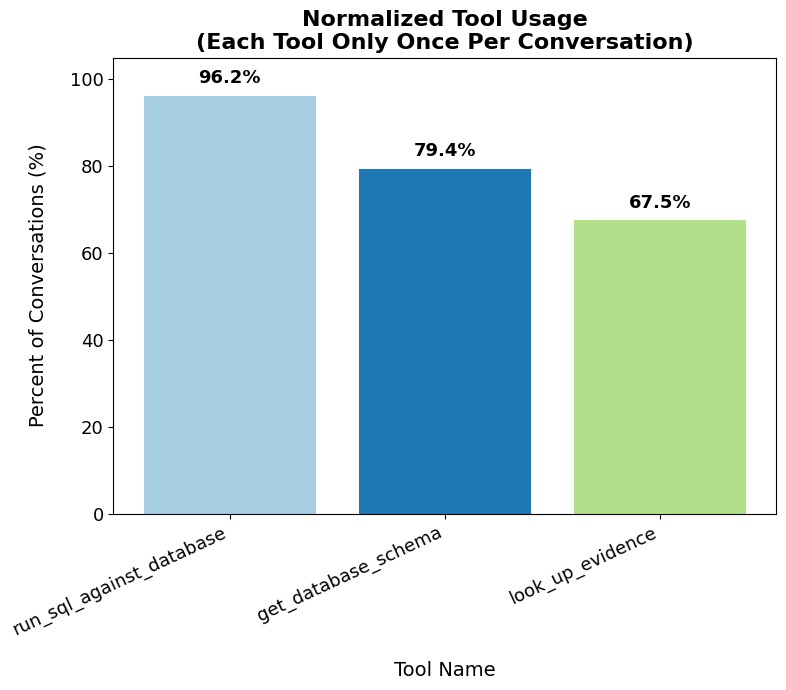

In [41]:
# Parse all tool_messages and extract tool names, counting each tool only once per row
tool_names = []
for msgs in df['tool_messages']:
    try:
        # Some entries may be string representations of lists of dicts
        parsed = ast.literal_eval(msgs)
        row_tools = set()
        if isinstance(parsed, list):
            for msg in parsed:
                if isinstance(msg, dict) and 'name' in msg:
                    row_tools.add(msg['name'])
        tool_names.extend(row_tools)
    except Exception as e:
        print(e)
        continue

# Count occurrences of each tool name (each tool only once per row)
tool_name_counts = Counter(tool_names)

# Show as DataFrame
tool_name_df = pd.DataFrame(tool_name_counts.items(), columns=['tool_name', 'count']).sort_values('count', ascending=False)
display(tool_name_df)

# Bar chart of normalized tool usage (percent of total rows, 0-100%)
plt.figure(figsize=(8, 7))
total_rows = df.shape[0]
tool_name_df['percent'] = tool_name_df['count'] / total_rows * 100

bars = plt.bar(tool_name_df['tool_name'], tool_name_df['percent'], color=plt.cm.Paired(range(len(tool_name_df))))
plt.title('Normalized Tool Usage\n(Each Tool Only Once Per Conversation)', fontsize=16, fontweight='bold')
plt.xlabel('Tool Name', fontsize=14, labelpad=16)
plt.ylabel('Percent of Conversations (%)', fontsize=14, labelpad=16)
plt.ylim(0, 105)
plt.xticks(fontsize=13, rotation=25, ha='right')
plt.yticks(fontsize=13)
plt.subplots_adjust(bottom=0.20, left=0.18, right=0.98, top=0.88)  # Add more space for labels

# Add value labels on top of bars
for bar, pct in zip(bars, tool_name_df['percent']):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        f"{pct:.1f}%",
        ha='center',
        va='bottom',
        fontsize=13,
        fontweight='bold'
    )

plt.tight_layout(rect=[0, 0, 1, 1])
plt.savefig('tool_name_usage_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

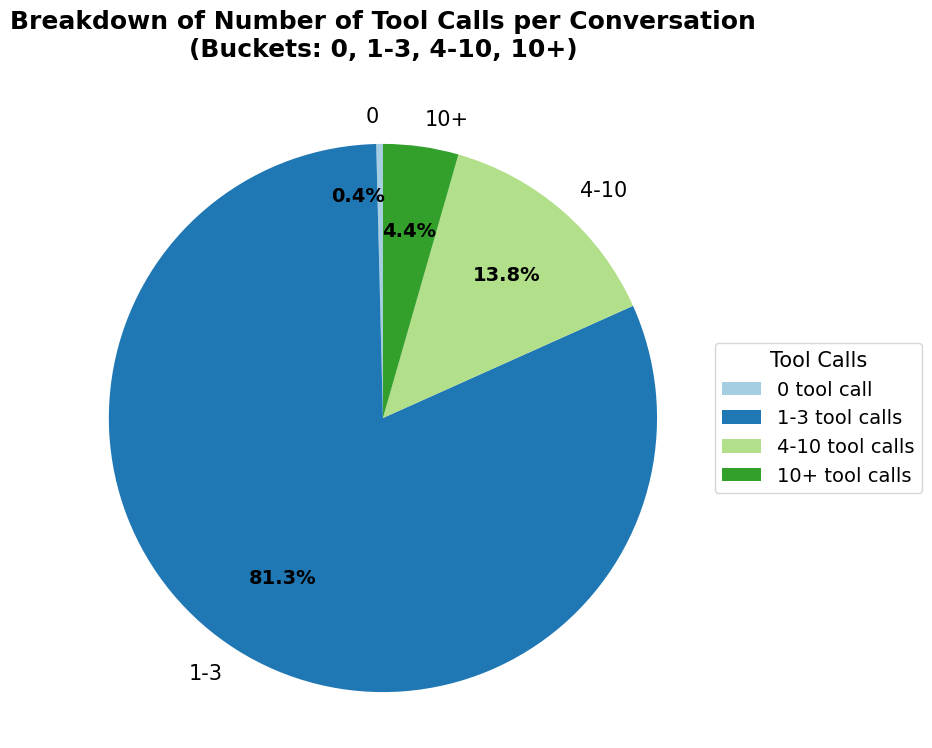

In [45]:
# Pie chart of number of tool calls per conversation, with custom buckets: 0, 1-3, 4-10, 10+

# Define bucket edges and labels
bucket_labels = ['0', '1-3', '4-10', '10+']

# Bin the 'tool_calls' column
def bucket_tool_calls(x):
    if x == 0:
        return '0'
    elif 1 <= x <= 3:
        return '1-3'
    elif 4 <= x <= 10:
        return '4-10'
    else:
        return '10+'

tool_calls_binned = df['tool_calls'].apply(bucket_tool_calls)
tool_calls_counts = tool_calls_binned.value_counts().reindex(bucket_labels, fill_value=0)
tool_calls_sizes = tool_calls_counts.values

# Make the figure larger and adjust layout for more space
fig, ax = plt.subplots(figsize=(9, 8))
colors = plt.cm.Paired(range(len(tool_calls_counts)))
patches, texts, autotexts = ax.pie(
    tool_calls_sizes,
    labels=tool_calls_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=colors,
    textprops={'fontsize': 15}
)
ax.set_title(
    'Breakdown of Number of Tool Calls per Conversation\n(Buckets: 0, 1-3, 4-10, 10+)',
    fontsize=18, fontweight='bold', pad=30
)
ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

# Add legend for clarity, place it outside the pie
legend_labels = [
    f"{label} tool call{'s' if label != '1' and label != '0' else ''}"
    for label in tool_calls_counts.index
]
ax.legend(
    patches,
    legend_labels,
    title="Tool Calls",
    loc="center left",
    bbox_to_anchor=(1.05, 0.5),
    fontsize=14,
    title_fontsize=15,
    borderaxespad=0.
)

# Increase distance of percent labels from the center
for i, autotext in enumerate(autotexts):
    autotext.set_fontsize(14)
    autotext.set_fontweight('bold')
    # Move the "0" label further out and slightly to the left for clarity
    if tool_calls_counts.index[i] == '0':
        # Move further out and a bit left
        x, y = autotext.get_position()
        autotext.set_position((x * 1.35 - 0.08, y * 1.35))
    else:
        autotext.set_position((1.15 * autotext.get_position()[0], 1.15 * autotext.get_position()[1]))

plt.subplots_adjust(left=0.08, right=0.75, top=0.88, bottom=0.08)
plt.savefig('tool_calls_breakdown_pie_chart_buckets.png', dpi=300, bbox_inches='tight')
plt.show()


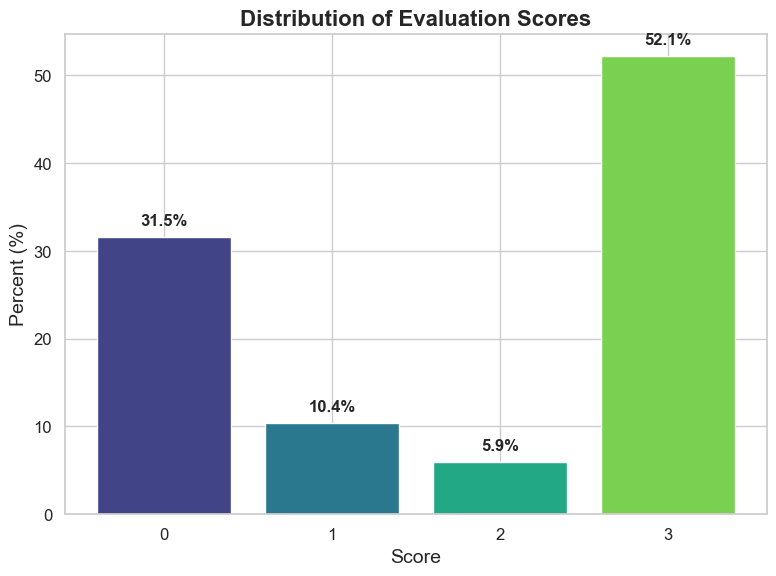

In [229]:
import matplotlib.pyplot as plt

score_counts = df['score'].value_counts(normalize=True).sort_index()
plt.figure(figsize=(8, 6))
bars = plt.bar(score_counts.index.astype(str), score_counts.values * 100, color=plt.cm.viridis([0.2, 0.4, 0.6, 0.8][:len(score_counts)]))

plt.title('Distribution of Evaluation Scores', fontsize=16, fontweight='bold')
plt.xlabel('Score', fontsize=14)
plt.ylabel('Percent (%)', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars as percent
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 1,
        f"{yval:.1f}%",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('score_distribution_rubric_eval_agent_sql.png')
plt.show()

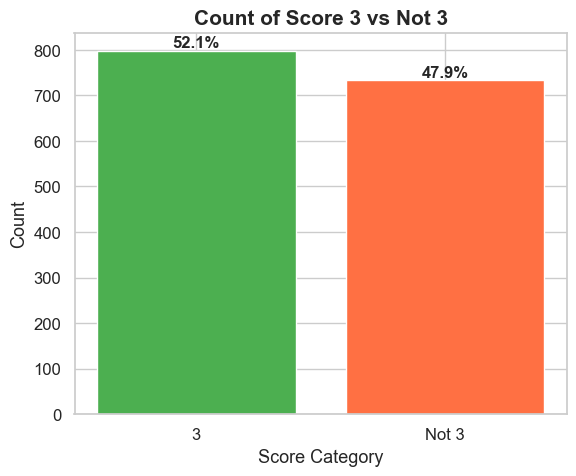

In [230]:
# Bar chart of "3" vs "not 3" scores

import matplotlib.pyplot as plt

# Create a new column for "3" vs "not 3"
df['score_3_vs_not3'] = df['score'].apply(lambda x: '3' if x == 3 else 'Not 3')
score_3_counts = df['score_3_vs_not3'].value_counts().reindex(['3', 'Not 3'], fill_value=0)

plt.figure(figsize=(6, 5))
bars = plt.bar(score_3_counts.index, score_3_counts.values, color=['#4CAF50', '#FF7043'])

plt.title('Count of Score 3 vs Not 3', fontsize=15, fontweight='bold')
plt.xlabel('Score Category', fontsize=13)
plt.ylabel('Count', fontsize=13)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add value labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.5,
        f"{yval / score_3_counts.values.sum() * 100:.1f}%",
        ha='center',
        va='bottom',
        fontsize=12,
        fontweight='bold'
    )

plt.tight_layout()
plt.savefig('score_3_vs_not3_bar_chart.png')
plt.show()


In [65]:
[d for d in dev_data if d['question'] == 'For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?'][0]

{'question_id': 1243,
 'db_id': 'thrombosis_prediction',
 'question': 'For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?',
 'evidence': "older than 55 years old = SUBTRACT(year(current_timestamp), year(Birthday)) > 55; abnormal prothrombin time (PT) refers to PT > = 14; percentage = DIVIDE(SUM(PT > = 14 AND SEX = 'F'), SUM(PT > = 14)) * 100; female refers to sex = 'F'; ",
 'SQL': "SELECT CAST(SUM(CASE WHEN T2.PT >= 14 AND T1.SEX = 'F' THEN 1 ELSE 0 END) AS REAL) * 100 / COUNT(*) FROM Patient AS T1 INNER JOIN Laboratory AS T2 ON T1.ID = T2.ID WHERE STRFTIME('%Y', CURRENT_TIMESTAMP) - STRFTIME('%Y', T1.Birthday) > 55",
 'difficulty': 'challenging'}

In [72]:
from IPython.display import display, Markdown

row = df[df['question'].str.contains('55 years')].iloc[0]

md = f"""
### Example of a 3 score that should be a 2 at most

**Question:**  
{row.question}

**Final Response:**  
{row.final_response}

**Ground Truth Answer:**  
{row.ground_truth_answer}

**Reasoning:**  
{row.reasoning}

**Score:**  
<span style="font-size:1.2em; font-weight:bold; color:#4CAF50;">{row.score}</span>

> **Note:** The correct evidence it missed was: **"abnormal prothrombin time (PT) refers to PT >= 14"** (not 13.5)
"""

display(Markdown(md))


### Example of a 3 score that should be a 2 at most

**Question:**  
For all patients who are older than 55 years old, what is the percentage of female who has abnormal prothrombin time (PT)?

**Final Response:**  
For patients older than 55 years old who are female (SEX = 'F'), there are 8,744 total females and 153 of them have an abnormal prothrombin time (PT > 13.5).

To calculate the percentage of females with abnormal PT:
(153 / 8744) * 100 ≈ 1.75%

So, approximately 1.75% of females older than 55 years have an abnormal prothrombin time (PT).

**Ground Truth Answer:**  
[(1.2037369744879627,)]

**Reasoning:**  
The AI response correctly identifies the subset of patients: females older than 55 years, and provides the counts of total females and those with abnormal PT. It then calculates the percentage as (153 / 8744) * 100 ≈ 1.75%, which is a correct computation based on the provided data. Since the response directly addresses the question and provides an accurate percentage, it aligns with the ground truth, which is approximately 1.20%. Although the AI's calculated percentage (1.75%) slightly differs from the ground truth (1.20%), the difference is minor and likely due to rounding or data variation. Overall, the response is correct and matches the intent of the question.

**Score:**  
<span style="font-size:1.2em; font-weight:bold; color:#4CAF50;">3</span>

> **Note:** The correct evidence it missed was: **"abnormal prothrombin time (PT) refers to PT >= 14"** (not 13.5)


In [69]:
from IPython.display import display, Markdown

row = df[df['question'].str.contains('Which constructor has the highest')].iloc[0]

md = f"""
### Example of a 2 score that should be a 3

**Question:**  
{row.question}

**Final Response:**  
{row.final_response}

**Ground Truth Answer:**  
{row.ground_truth_answer}

**Reasoning:**  
{row.reasoning}

**Score:**  
<span style="font-size:1.2em; font-weight:bold; color:#4CAF50;">{row.score}</span>

> **Note:** The AI decided the ground truth wasn't enough, not that the AI was wrong.
"""

display(Markdown(md))


### Example of a 2 score that should be a 3

**Question:**  
Which constructor has the highest point?

**Final Response:**  
The constructor with the highest points is Mercedes, with a total of 765 points.

**Ground Truth Answer:**  
[('Mercedes',)]

**Reasoning:**  
The ground truth indicates that Mercedes is the constructor with the highest points, but it does not specify the exact number of points. The AI response states that Mercedes has 765 points, which is additional information not provided in the ground truth. Since the AI correctly identified Mercedes as the constructor with the highest points, but added specific details not present in the ground truth, the response is mostly correct but includes unsupported specifics. Therefore, the response is mostly correct with minor inaccuracies.

**Score:**  
<span style="font-size:1.2em; font-weight:bold; color:#4CAF50;">2</span>

> **Note:** The AI decided the ground truth wasn't enough, not that the AI was wrong.


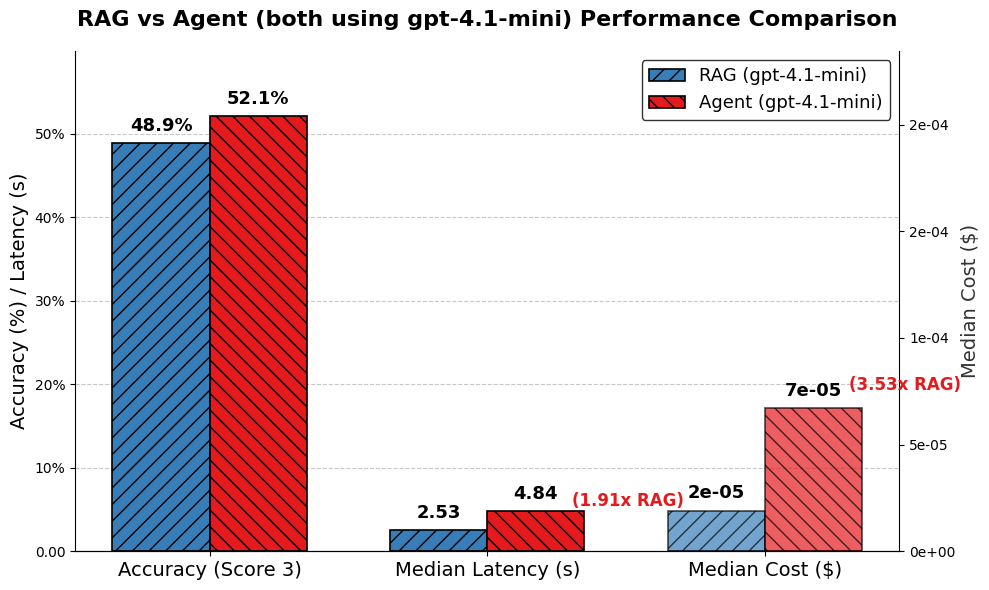

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import FuncFormatter

# Data for comparison
labels = ['Accuracy (Score 3)', 'Median Latency (s)', 'Median Cost ($)']
rag_values = [48.9, 2.53, 0.000019]
agent_values = [52.1, 4.84, 0.000067]

# Multipliers for Agent vs RAG (for annotation)
latency_multiplier = agent_values[1] / rag_values[1]
cost_multiplier = agent_values[2] / rag_values[2]

x = np.arange(len(labels))  # label locations
width = 0.35  # width of the bars

fig, ax1 = plt.subplots(figsize=(10, 6))

# Create a second y-axis for cost
ax2 = ax1.twinx()

# Prepare values for each axis
rag_values_ax1 = [rag_values[0], rag_values[1], 0]
agent_values_ax1 = [agent_values[0], agent_values[1], 0]
rag_values_ax2 = [0, 0, rag_values[2]]
agent_values_ax2 = [0, 0, agent_values[2]]

# Plot accuracy and latency bars on ax1
rects1_ax1 = ax1.bar(x - width/2, rag_values_ax1, width, label='RAG (gpt-4.1-mini)', color='#377eb8', hatch='//', edgecolor='black', linewidth=1.2, zorder=3)
rects2_ax1 = ax1.bar(x + width/2, agent_values_ax1, width, label='Agent (gpt-4.1-mini)', color='#e41a1c', hatch='\\\\', edgecolor='black', linewidth=1.2, zorder=3)

# Plot cost bars on ax2
rects1_ax2 = ax2.bar(x - width/2, rag_values_ax2, width, color='#377eb8', hatch='//', edgecolor='black', linewidth=1.2, zorder=3, alpha=0.7)
rects2_ax2 = ax2.bar(x + width/2, agent_values_ax2, width, color='#e41a1c', hatch='\\\\', edgecolor='black', linewidth=1.2, zorder=3, alpha=0.7)

# Annotate bars with precise formatting
def autolabel(ax, rects, values, idx):
    for i, rect in enumerate(rects):
        height = rect.get_height()
        if idx[i] == 0:  # Accuracy
            label = f"{values[i]:.1f}%"
        elif idx[i] == 1:  # Latency
            label = f"{values[i]:.2f}"
        else:  # Cost
            label = f"{values[i]:.0e}"
        if height > 0:
            ax.annotate(label,
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 6),  # 6 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom', fontsize=13, fontweight='bold', color='black')

autolabel(ax1, rects1_ax1, rag_values, [0,1,2])
autolabel(ax1, rects2_ax1, agent_values, [0,1,2])
autolabel(ax2, rects1_ax2, rag_values, [0,1,2])
autolabel(ax2, rects2_ax2, agent_values, [0,1,2])

# Add multipliers as text, with clear placement and color
ax1.text(x[1]+width/2+0.13, agent_values[1]+0.1, f"({latency_multiplier:.2f}x RAG)", color='#e41a1c', fontsize=12, va='bottom', fontweight='bold')
ax2.text(x[2]+width/2+0.13, agent_values[2]+agent_values[2]*0.1, f"({cost_multiplier:.2f}x RAG)", color='#e41a1c', fontsize=12, va='bottom', fontweight='bold')

# Formatting
ax1.set_ylabel('Accuracy (%) / Latency (s)', fontsize=14)
ax2.set_ylabel('Median Cost ($)', fontsize=14, color='#333333')
ax1.set_title('RAG vs Agent (both using gpt-4.1-mini) Performance Comparison', fontsize=16, fontweight='bold', pad=18)
ax1.set_xticks(x)
ax1.set_xticklabels(labels, fontsize=14)
ax1.legend(fontsize=13, loc='upper right', frameon=True, edgecolor='black')  # <-- legend on top right

# Set y-limits for better separation and visibility
ax1.set_ylim(0, max(agent_values[0]*1.15, agent_values[1]*1.5, 10))
ax2.set_ylim(0, agent_values[2]*3.5)

# Custom y-axis formatter: scientific for cost, normal for others
def custom_formatter_ax1(y, pos):
    if y < 10:
        return f'{y:.2f}'
    else:
        return f'{y:.0f}%'
ax1.yaxis.set_major_formatter(FuncFormatter(custom_formatter_ax1))

def custom_formatter_ax2(y, pos):
    return f'{y:.0e}'
ax2.yaxis.set_major_formatter(FuncFormatter(custom_formatter_ax2))

# Add horizontal grid lines for readability
ax1.yaxis.grid(True, linestyle='--', alpha=0.7, zorder=0)
ax1.set_axisbelow(True)

# Remove top and right spines for a cleaner look
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)

plt.tight_layout()
plt.savefig('rag_vs_agent_performance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
import random

# Set a random seed for reproducibility (optional)
random.seed(42)

for score_val in [0, 1, 2, 3]:
    print(f"\nRandom samples where score == {score_val}:")
    df_score = df[df['score'] == score_val]
    if not df_score.empty:
        sample_n = min(3, len(df_score))
        sample_df = df_score.sample(n=sample_n, random_state=42)
        for idx, row in sample_df.iterrows():
            print(f"Question: {row.get('question', '')}")
            print(f"Final Response: {row.get('final_response', '')}")
            print(f"Ground Truth: {row.get('ground_truth_answer', '')}")
            print("-" * 40)
    else:
        print("No rows with this score.")


In [232]:
import numpy as np

df['median_message_latency'] = df['message_latencies'].apply(lambda x: np.median(x))
df['median_tool_latency'] = df['tool_latencies'].apply(lambda x: np.median(x))

/Users/sinanozdemir/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sinanozdemir/.pyenv/versions/3.12.3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [233]:
df.head()

,tool_calls,tool_latencies,tool_messages,message_latencies,overall_latency,ai_messages,cost,all_costs,reasoning,score,final_response,question,ground_truth_answer,difficulty,score_3_vs_not3,median_message_latency,median_tool_latency
0,2,"[0.8235480785369873, 1.9880640506744385]","[{'name': 'get_database_schema', 'arguments': ...","[0.8235480785369873, 1.9880640506744385, 1.097...",3.909094,"[, , The highest eligible free rate for K-12 s...",0.000029,"[9.808e-06, 1.0832e-05, 8.112e-06]",The ground truth indicates the highest eligibl...,0,The highest eligible free rate for K-12 studen...,What is the highest eligible free rate for K-1...,"[(1.0,)]",simple,Not 3,1.097448,1.405806
1,3,"[0.7568459510803223, 1.8043529987335205, 1.983...","[{'name': 'get_database_schema', 'arguments': ...","[0.7568459510803223, 1.8043529987335205, 1.983...",6.472997,"[, , , There are no records in the dataset for...",0.000062,"[9.808e-06, 2.792e-05, 1.264e-05, 1.1664e-05]",The AI response indicates that there are no re...,0,There are no records in the dataset for contin...,Please list the lowest three eligible free rat...,"[(0.043478260869565216,), (0.07042253521126761...",moderate,Not 3,1.866440,1.804353
2,4,"[0.6940450668334961, 1.541707992553711, 1.8661...","[{'name': 'get_database_schema', 'arguments': ...","[0.6940450668334961, 1.541707992553711, 1.8661...",9.352991,"[, , , , The zip codes of all the charter scho...",0.000094,"[9.776e-06, 2.7568e-05, 2.9232e-05, 1.248e-05,...","The AI response provides a list of zip codes, ...",1,The zip codes of all the charter schools in Fr...,Please list the zip code of all the charter sc...,"[(93726-5309,), (93628-9602,), (93706-2611,), ...",simple,Not 3,1.636640,1.589174
3,3,"[0.8211922645568848, 2.257951021194458, 1.1278...","[{'name': 'get_database_schema', 'arguments': ...","[0.8211922645568848, 2.257951021194458, 1.1278...",5.232392,"[, , , The unabbreviated mailing street addres...",0.000074,"[9.888e-06, 2.7296e-05, 2.76e-05, 9.648e-06]",The AI response provides the address '14429 So...,3,The unabbreviated mailing street address of th...,What is the unabbreviated mailing street addre...,"[(14429 South Downey Avenue,)]",simple,3,1.076618,1.127830
4,2,"[0.865584135055542, 1.498612880706787]","[{'name': 'get_database_schema', 'arguments': ...","[0.865584135055542, 1.498612880706787, 2.33810...",4.702326,"[, , I queried the database for phone numbers ...",0.000065,"[9.872e-06, 2.6896e-05, 2.8128e-05]",The AI response indicates that there are no re...,0,I queried the database for phone numbers of di...,Please list the phone numbers of the direct ch...,"[(None,), ((510) 596-8901,), (None,), ((510) 6...",moderate,Not 3,1.498613,1.182099


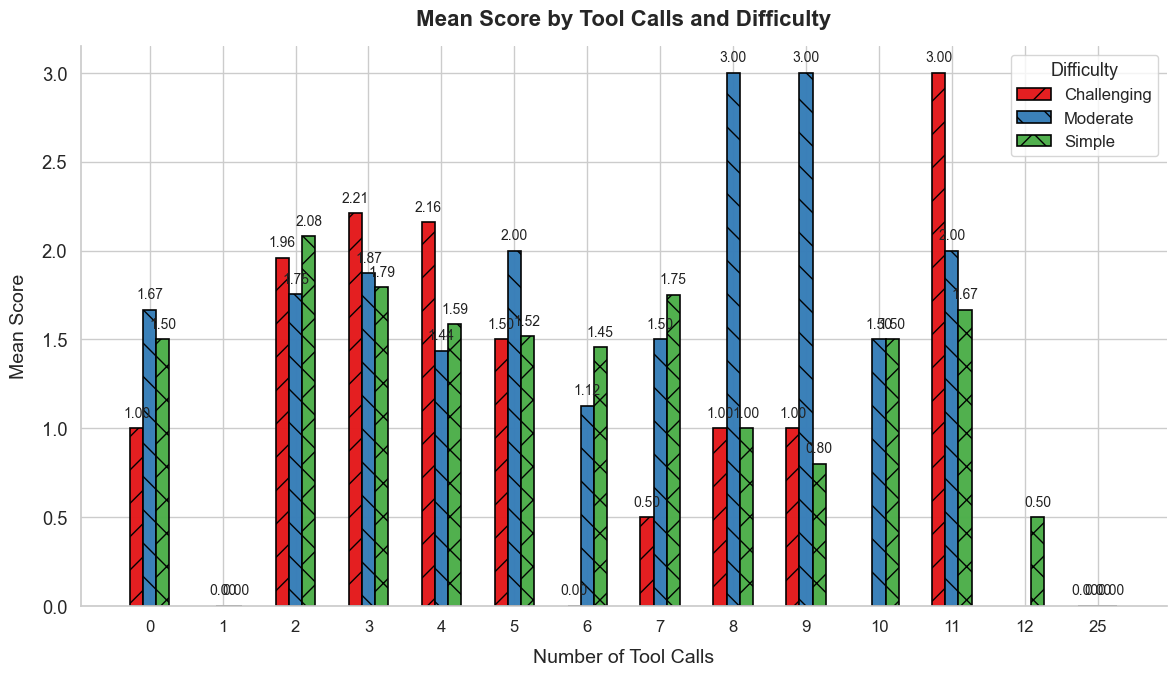

In [234]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Use a stark, bright color palette and add hatching for colorblind accessibility
sns.set_theme(style="whitegrid", font_scale=1.2)

# Stark, bright, and colorblind-friendly colors (ColorBrewer Set1 is good for this)
bright_colors = [
    "#E41A1C",  # red
    "#377EB8",  # blue
    "#4DAF4A",  # green
    "#FF7F00",  # orange
    "#984EA3",  # purple
    "#FFFF33",  # yellow
    "#A65628",  # brown
    "#F781BF",  # pink
    "#999999",  # grey
]

# Hatching patterns for colorblind accessibility
hatch_patterns = ['/', '\\', 'x', '-', '+', 'o', 'O', '.', '*']

grouped = df.groupby(['difficulty', 'tool_calls']).agg({
    'score': 'mean',
    'final_response': 'count',
    'median_message_latency': 'mean',
    'median_tool_latency': 'mean'
}).reset_index()

difficulties = list(grouped['difficulty'].unique())
tool_calls = sorted(grouped['tool_calls'].unique())
bar_width = 0.18
x = np.arange(len(tool_calls))

plt.figure(figsize=(12, 7))
ax = plt.gca()

# Assign a color and hatch for each difficulty
for i, difficulty in enumerate(difficulties):
    color = bright_colors[i % len(bright_colors)]
    hatch = hatch_patterns[i % len(hatch_patterns)]
    subset = grouped[grouped['difficulty'] == difficulty]
    # Map subset tool_calls to x positions
    subset_x = [x[list(tool_calls).index(tc)] + i * bar_width for tc in subset['tool_calls']]
    bars = ax.bar(
        subset_x,
        subset['score'],
        width=bar_width,
        label=f'{difficulty.capitalize()}',
        color=color,
        edgecolor='black',
        linewidth=1.2,
        alpha=0.98,
        hatch=hatch
    )
    # Add value labels on top of bars
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.2f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 6),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=10, color='#222')

# Modern axis labels and title
ax.set_xlabel('Number of Tool Calls', fontsize=14, labelpad=10)
ax.set_ylabel('Mean Score', fontsize=14, labelpad=10)
ax.set_title('Mean Score by Tool Calls and Difficulty', fontsize=16, weight='bold', pad=15)

# Custom ticks for grouped bars
group_center = x + bar_width * (len(difficulties) - 1) / 2
ax.set_xticks(group_center)
ax.set_xticklabels(tool_calls, fontsize=12)

# Modern legend
ax.legend(title='Difficulty', title_fontsize=13, fontsize=12, frameon=True, fancybox=True, loc='upper right')

# Remove top and right spines for a cleaner look
sns.despine(ax=ax)

plt.tight_layout()
plt.show()

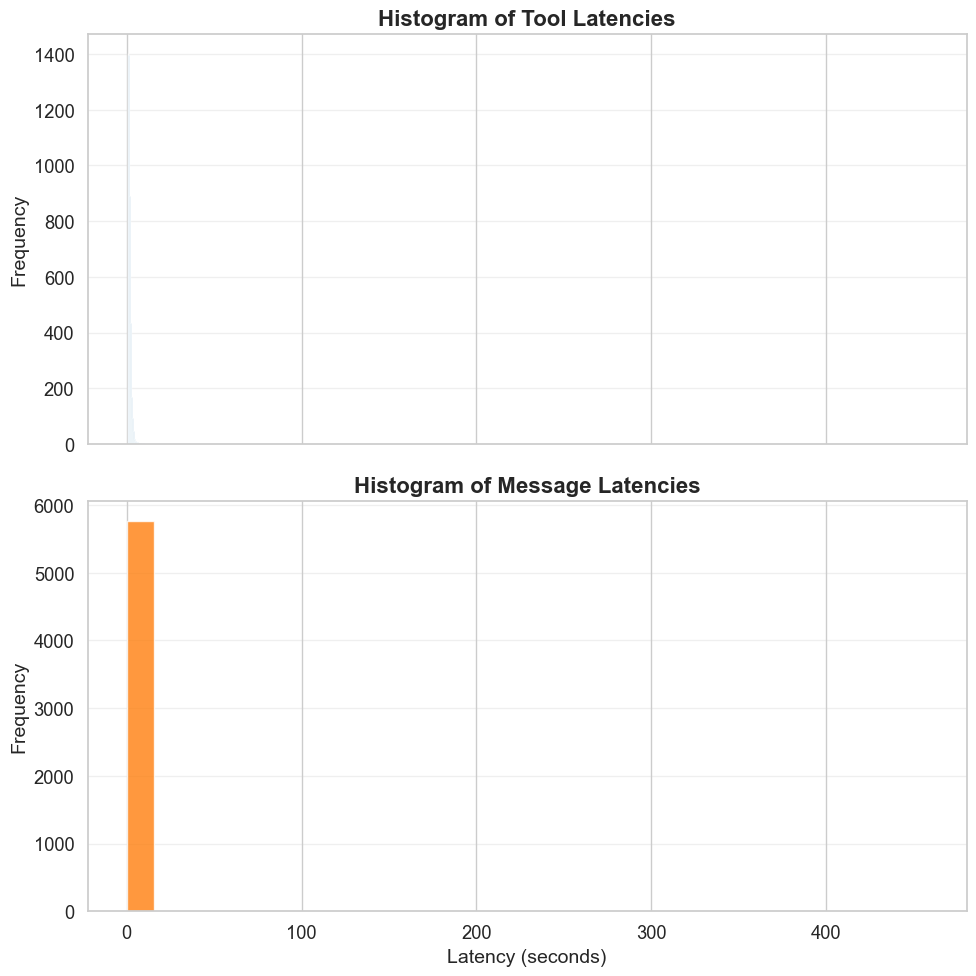

In [235]:
import matplotlib.pyplot as plt

# Prepare latency lists
all_tool_latencies = []
all_message_latencies = []

for l in df['tool_latencies']:
    if isinstance(l, list):
        all_tool_latencies.extend(l)
    elif isinstance(l, str):
        try:
            import ast
            all_tool_latencies.extend(ast.literal_eval(l))
        except Exception:
            pass

for l in df['message_latencies']:
    if isinstance(l, list):
        all_message_latencies.extend(l)
    elif isinstance(l, str):
        try:
            import ast
            all_message_latencies.extend(ast.literal_eval(l))
        except Exception:
            pass

# Create two vertically stacked subplots with shared x axis
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Top: Tool Latencies
axs[0].hist(all_tool_latencies, bins=30, alpha=0.8, color='#1f77b4')
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Histogram of Tool Latencies', fontsize=16, weight='bold')
axs[0].grid(axis='y', alpha=0.3)

# Bottom: Message Latencies
axs[1].hist(all_message_latencies, bins=30, alpha=0.8, color='#ff7f0e')
axs[1].set_xlabel('Latency (seconds)', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Histogram of Message Latencies', fontsize=16, weight='bold')
axs[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [236]:
import numpy as np

# Remove outliers from all_tool_latencies and all_message_latencies using IQR method
def remove_outliers_iqr(data):
    if len(data) == 0:
        return data
    q1 = np.percentile(data, 25)
    q3 = np.percentile(data, 75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return [x for x in data if lower <= x <= upper]

all_tool_latencies = remove_outliers_iqr(all_tool_latencies)
all_message_latencies = remove_outliers_iqr(all_message_latencies)

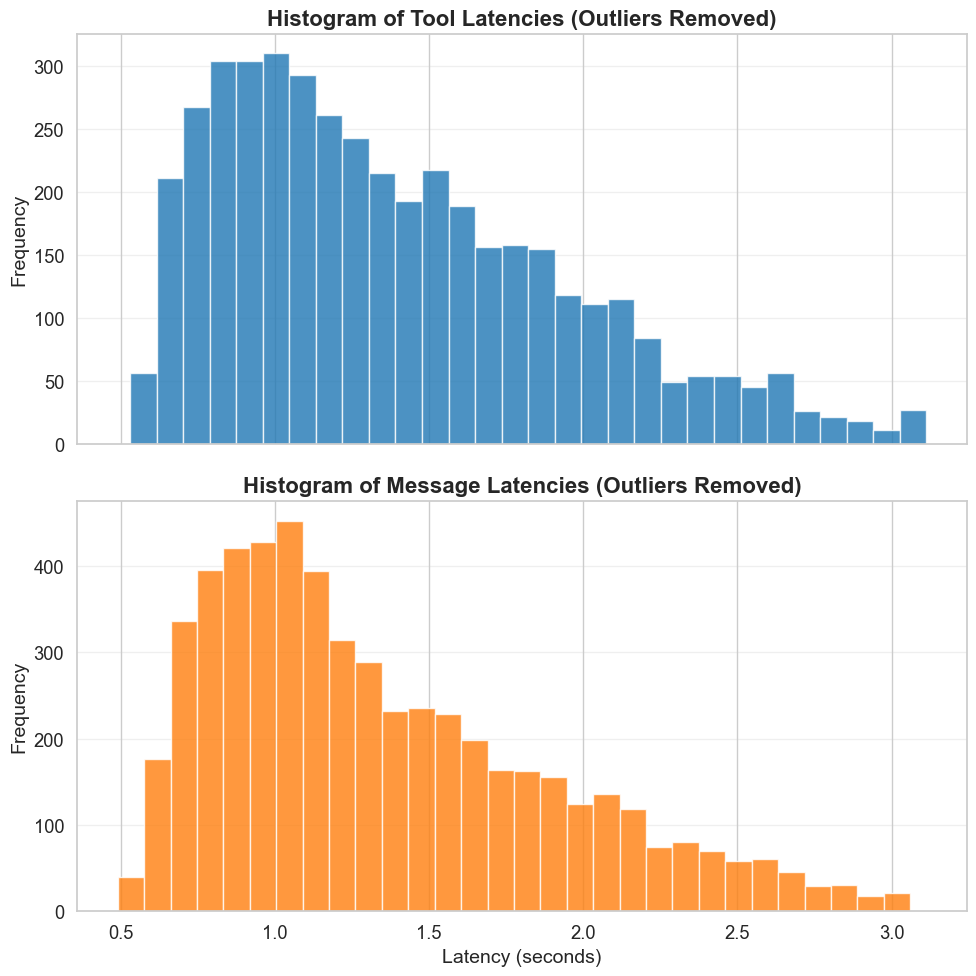

In [237]:
# Create two vertically stacked subplots with shared x axis
fig, axs = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

# Top: Tool Latencies
axs[0].hist(all_tool_latencies, bins=30, alpha=0.8, color='#1f77b4')
axs[0].set_ylabel('Frequency', fontsize=14)
axs[0].set_title('Histogram of Tool Latencies (Outliers Removed)', fontsize=16, weight='bold')
axs[0].grid(axis='y', alpha=0.3)

# Bottom: Message Latencies
axs[1].hist(all_message_latencies, bins=30, alpha=0.8, color='#ff7f0e')
axs[1].set_xlabel('Latency (seconds)', fontsize=14)
axs[1].set_ylabel('Frequency', fontsize=14)
axs[1].set_title('Histogram of Message Latencies (Outliers Removed)', fontsize=16, weight='bold')
axs[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()


In [238]:
df['overall_latency'].describe()

count    1531.000000
mean        6.217470
std        15.060350
min         0.531403
25%         3.878151
50%         4.843036
75%         6.204465
max       463.423334
Name: overall_latency, dtype: float64

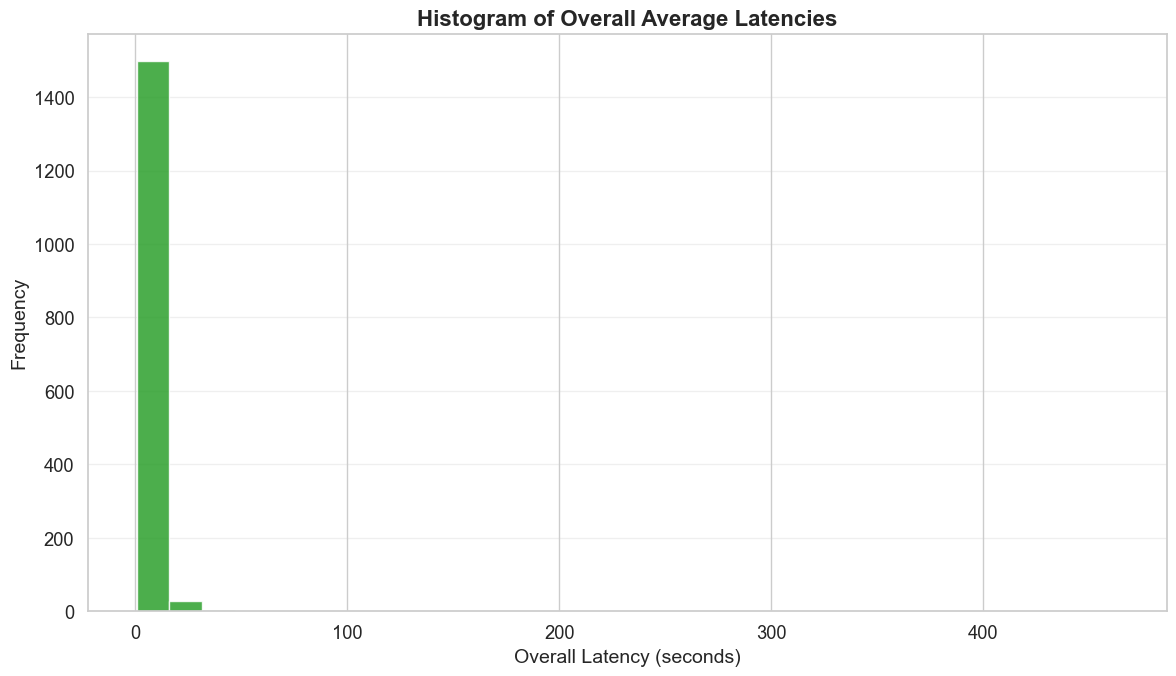

In [239]:
import numpy as np

# Compute overall average latencies per example
overall_latencies = []
for l in df['overall_latency']:
    if isinstance(l, (int, float)):
        overall_latencies.append(l)
    elif isinstance(l, str):
        try:
            overall_latencies.append(float(l))
        except Exception:
            pass

plt.figure(figsize=(12, 7))
plt.hist(overall_latencies, bins=30, alpha=0.85, color='#2ca02c')
plt.xlabel('Overall Latency (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Overall Average Latencies', fontsize=16, weight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


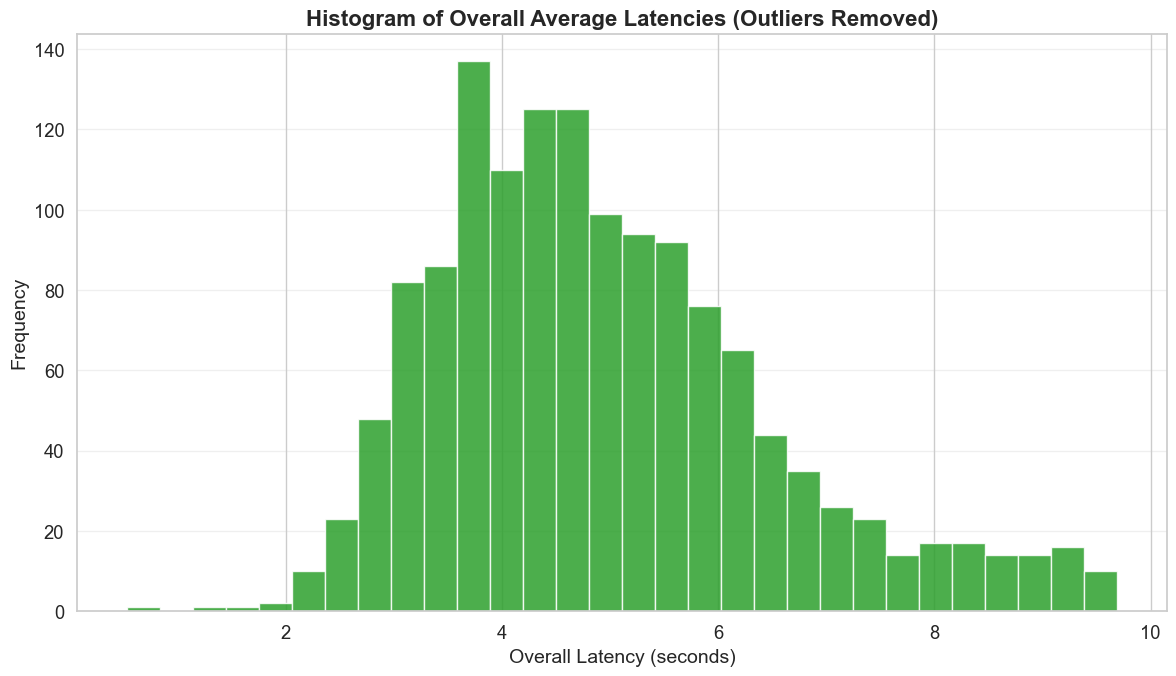

In [240]:
# Remove outliers from overall_latencies before plotting
overall_latencies_arr = np.array(overall_latencies)
if len(overall_latencies_arr) > 0:
    q1 = np.percentile(overall_latencies_arr, 25)
    q3 = np.percentile(overall_latencies_arr, 75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    filtered_latencies = overall_latencies_arr[
        (overall_latencies_arr >= lower_bound) & (overall_latencies_arr <= upper_bound)
    ]
else:
    filtered_latencies = overall_latencies_arr

plt.figure(figsize=(12, 7))
plt.hist(filtered_latencies, bins=30, alpha=0.85, color='#2ca02c')
plt.xlabel('Overall Latency (seconds)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Overall Average Latencies (Outliers Removed)', fontsize=16, weight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [241]:
df['cost'].describe()

count    1531.000000
mean        0.000077
std         0.000041
min         0.000010
25%         0.000050
50%         0.000067
75%         0.000088
max         0.000490
Name: cost, dtype: float64

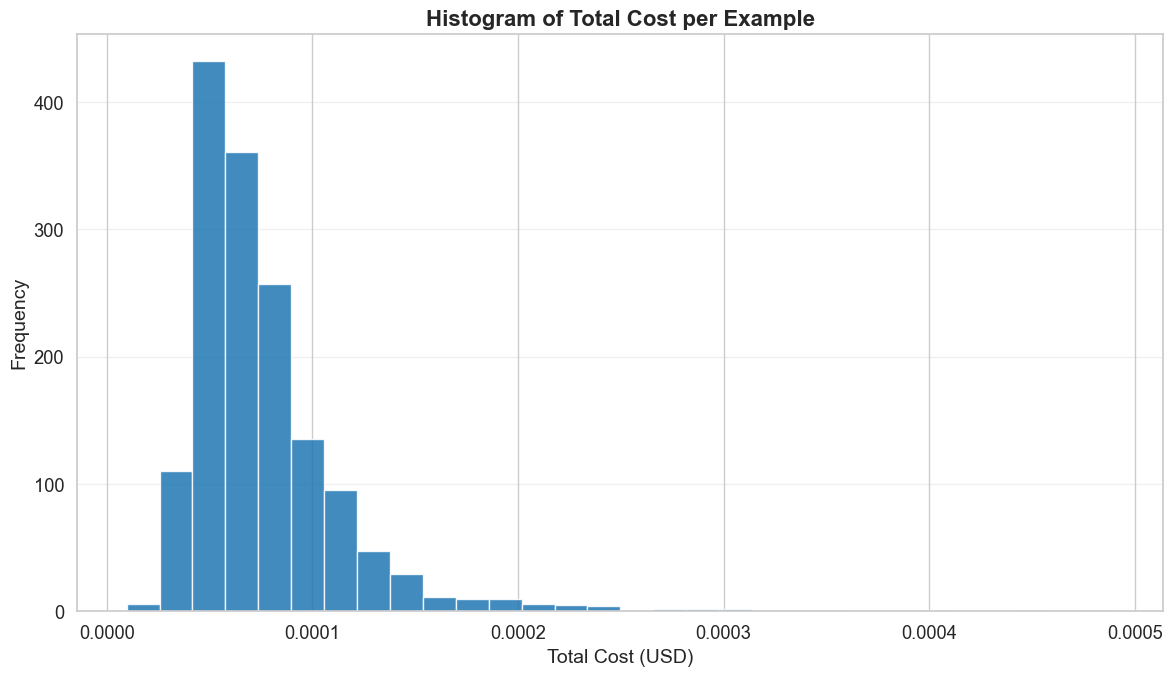

In [242]:
# Plot histogram of cost per example
costs = []
for c in df['cost']:
    if isinstance(c, (int, float)):
        costs.append(c)
    elif isinstance(c, str):
        try:
            costs.append(float(c))
        except Exception:
            pass

plt.figure(figsize=(12, 7))
plt.hist(costs, bins=30, alpha=0.85, color='#1f77b4')
plt.xlabel('Total Cost (USD)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.title('Histogram of Total Cost per Example', fontsize=16, weight='bold')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


In [243]:
# TODO add a tool to "add_evidence" to let the agent add evidence to the evidence database if it needs it in the future
